In [2]:
# imports
import pandas as pd
import optuna # pip install optuna
import matplotlib.pyplot as plt
import numpy as np

#froms
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from prophet.diagnostics import cross_validation, performance_metrics


In [4]:
# globales
df = pd.read_csv("../../data/dataset_training.csv", encoding="ISO-8859-1", low_memory=False)
dfPredicReal = pd.read_csv("../../data/dataset_prediction.csv", encoding="ISO-8859-1", low_memory=False)
print(f'\n DF limpio:')
print(df.info())
#scaling_factor = 1000 



 DF limpio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415181 entries, 0 to 415180
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   415181 non-null  int64  
 1   InvoiceNo    415181 non-null  object 
 2   StockCode    415181 non-null  object 
 3   Description  415181 non-null  object 
 4   Quantity     415181 non-null  int64  
 5   InvoiceDate  415181 non-null  object 
 6   UnitPrice    415181 non-null  float64
 7   CustomerID   415181 non-null  float64
 8   Country      415181 non-null  object 
 9   TotalSales   415181 non-null  float64
 10  Year         415181 non-null  int64  
 11  Month        415181 non-null  int64  
 12  Day          415181 non-null  int64  
 13  DayOfWeek    415181 non-null  int64  
 14  Season       415181 non-null  object 
dtypes: float64(3), int64(6), object(6)
memory usage: 47.5+ MB
None


In [6]:
# paso a datetime por si acaso
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# se necesitan dos columnas 'ds' e 'y', ds son las fechas, 'y' los valores que se quiere predecir
#dfPreparacion = df.set_index('InvoiceDate').resample('h')['Total'].sum().reset_index()

dfPreparacion= df.groupby(df['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()


# añadimos todos los domingos al df
dfPreparacion['InvoiceDate'] = pd.to_datetime(dfPreparacion['InvoiceDate'])
dfPreparacion = dfPreparacion.set_index('InvoiceDate').resample('D').sum().interpolate().reset_index()

dfPreparacion.columns = ['ds', 'y']
dfPreparacion['ds'] = pd.to_datetime(dfPreparacion['ds'])
#dfPreparacion['y'] = dfPreparacion['y'] * scaling_factor
print(f'\n DF de preparacion:')
print(dfPreparacion.info())
print(dfPreparacion.head())



 DF de preparacion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      342 non-null    datetime64[ns]
 1   y       342 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.5 KB
None
          ds         y
0 2010-12-01  31033.52
1 2010-12-02  26161.82
2 2010-12-03  22908.14
3 2010-12-04      0.00
4 2010-12-05  21972.42


In [8]:
# para el calculo de mae
dfPredicReal['InvoiceDate'] = pd.to_datetime(dfPredicReal['InvoiceDate'])
yReal=dfPredicReal.groupby(dfPredicReal['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()
#yReal = dfPredicReal.set_index('InvoiceDate').resample('h')['Total'].sum().reset_index()
yReal['InvoiceDate'] = pd.to_datetime(yReal['InvoiceDate'])
#Añadimos fechas que faltan
yReal = yReal.set_index('InvoiceDate').resample('D').mean().fillna(0)
yReal = yReal.reset_index()

print(yReal.info())
print(yReal.head())

# dejamos solo el valor
yRealValues= yReal['TotalSales'].values
print(f"\n Sin fecha:")
print(yRealValues)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceDate  32 non-null     datetime64[ns]
 1   TotalSales   32 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 644.0 bytes
None
  InvoiceDate  TotalSales
0  2011-11-08    39681.92
1  2011-11-09    30888.52
2  2011-11-10    37581.64
3  2011-11-11    38162.18
4  2011-11-12        0.00

 Sin fecha:
[39681.92 30888.52 37581.64 38162.18     0.   25752.48 32750.2  32119.82
 42345.4  38791.76 27401.78     0.   27056.37 29540.22 36823.67 37230.13
 36796.56 27982.22     0.   16633.18 33572.93 39506.46 36964.84 30135.74
 30453.86     0.   17447.66 53597.07 29847.81 27825.12 43834.98 18009.12]


In [10]:
# Empezamos con el modelo
#model = Prophet(changepoint_prior_scale=0.01)
#model = Prophet(
#    yearly_seasonality=True,
#    weekly_seasonality=True,
#    daily_seasonality=False,
#    changepoint_prior_scale=0.0009,
#    seasonality_mode="multiplicative")

# optinidos de optuna, despues lo he ajustado
model = Prophet(
   changepoint_prior_scale = 3.25,
   changepoint_range = 0.79,
   seasonality_prior_scale = 3.2,
   holidays_prior_scale = 4.85,
   seasonality_mode = "multiplicative",
   growth = "linear",
   weekly_seasonality = 10,
   yearly_seasonality = 3
)


model.add_country_holidays(country_name='UK')
model.add_seasonality(name="monthly", period=30.5, fourier_order=10)
model.add_seasonality(name='weekly', period=24*6, fourier_order=5)  # Ciclo semanal


# Fit
model.fit(dfPreparacion)

# df con fechas futuras, 32 en este caso
future = model.make_future_dataframe(periods=32, freq ='D')
# Realizar predicciones
forecast = model.predict(future)
#forecast['yhat'] = forecast['yhat'] / scaling_factor

13:28:14 - cmdstanpy - INFO - Chain [1] start processing
13:28:14 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Mostrar las predicciones , yhat predicion central, _lower y _upper intervalos de confianza
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(32))

            ds          yhat    yhat_lower    yhat_upper
342 2011-11-08  30284.777799  25465.394462  35077.097238
343 2011-11-09  26818.608142  22259.136792  31269.104416
344 2011-11-10  33623.579940  28983.934357  37944.990406
345 2011-11-11  27475.381842  22759.181827  32088.914278
346 2011-11-12  -6387.945465 -11309.357688  -2069.993305
347 2011-11-13  11377.096117   6291.010984  15840.388755
348 2011-11-14  26967.997869  21589.738274  31692.411154
349 2011-11-15  28532.854605  23361.723264  33287.633923
350 2011-11-16  28244.044443  22827.736020  33379.910819
351 2011-11-17  39750.018264  33001.235486  45350.376482
352 2011-11-18  31909.471044  26086.571971  37500.187148
353 2011-11-19  -7353.444424 -11896.303139  -2715.439392
354 2011-11-20  12642.693026   7389.957179  17631.967844
355 2011-11-21  33257.945424  25419.707461  39694.416644
356 2011-11-22  36755.670848  27005.732773  44301.056609
357 2011-11-23  30924.072108  22592.899448  37999.143230
358 2011-11-24  33521.050542  2

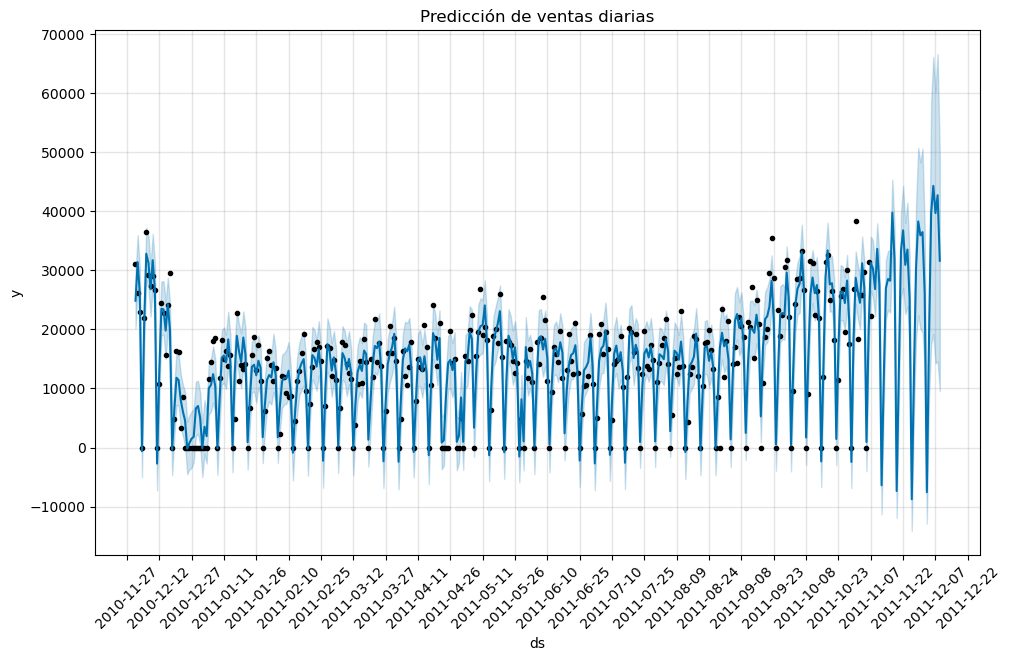

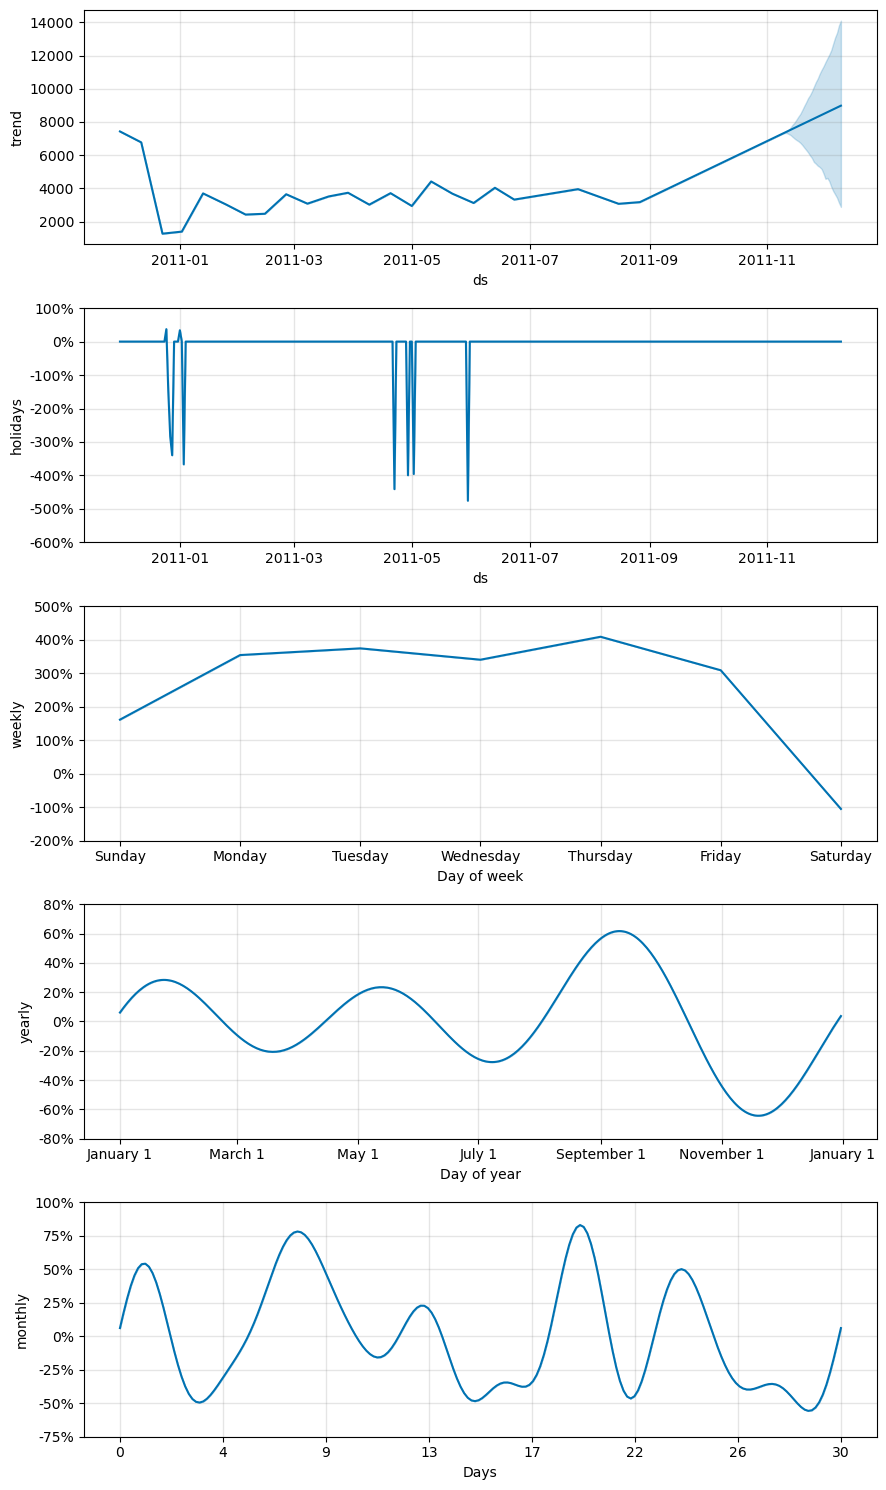

In [14]:
# Gráfico de predicción
fig = model.plot(forecast)
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(31)) 

plt.title('Predicción de ventas diarias')
plt.show()


# Componentes del modelo
fig2 = model.plot_components(forecast)
plt.show()

In [16]:
yPred = forecast['yhat'].tail(32)
yPred = yPred.reset_index(drop=True)
yPred.head()
yPredValues= yPred.values

mae=mean_absolute_error(yRealValues, yPredValues)
print('MAE: %.3f' % mae)
relativeMae = (mae / dfPreparacion["y"].mean()) * 100
print(f"MAE relativo: {relativeMae:.2f}%")

MAE: 6518.753
MAE relativo: 47.50%


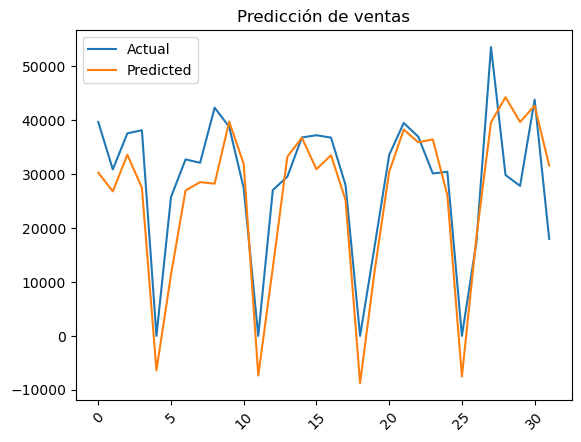

In [18]:
# plot expected vs actual
plt.plot(yRealValues, label='Actual')
plt.plot(yPredValues, label='Predicted')
plt.legend()
plt.xticks(rotation=45)  
plt.title('Predicción de ventas')
plt.show()